# Viewing the AXI-Stream Interface

In this notebook, we will show how to visualize the timing for the interaction between the Vitis IP and processor using the AXI-Stream interface.  Before running the notebook, you should complete the steps for [running the C/RTL co-simulation](https://sdrangan.github.io/hwdesign/fifoif).  This step will create a [**Value Change Dump**](https://en.wikipedia.org/wiki/Value_change_dump)  or **VCD** file with the values for all the signals between the IP and processor.


## Parsing the VCD file


First we import the relevant packages.

In [1]:
from vcdvcd import VCDVCD
import matplotlib.pyplot as plt

We parse the VCD file using the `VCDVCD` package.  The parsed data is in the `vcd` object.

In [2]:
# Check if VCD file exists
import os
fn = os.path.join(os.getcwd(), '..', 'fifo_fun_vitis', 'vcd', 'dump.vcd')
if not os.path.exists(fn):
    raise FileNotFoundError(f"VCD file not found: {fn}")

# Parse the VCD file
vcd = VCDVCD(fn, signals=None, store_tvs=True)




The RTL simulation records traces for a large number of signals.  You can get a full list with the following command.  You will see that there are over 200 such signals.

In [3]:
nsig = len(vcd.signals)
print(f"Number of signals in VCD: {nsig}")
print(vcd.signals[:5])


Number of signals in VCD: 642
['apatb_simp_fun_top.AESL_clock', 'apatb_simp_fun_top.rst', 'apatb_simp_fun_top.dut_rst', 'apatb_simp_fun_top.start', 'apatb_simp_fun_top.ce']


In [ ]:
# Find the signals with TDATA and TREADY in their names
tdatas = [s for s in vcd.signals if 'TDATA' in s]
vcd

tdatas

['apatb_simp_fun_top.cmd_stream_TDATA[31:0]',
 'apatb_simp_fun_top.result_stream_TDATA[31:0]',
 'apatb_simp_fun_top.AESL_inst_simp_fun.cmd_stream_TDATA[31:0]',
 'apatb_simp_fun_top.AESL_inst_simp_fun.result_stream_TDATA[31:0]',
 'apatb_simp_fun_top.AESL_inst_simp_fun.cmd_stream_TDATA_blk_n',
 'apatb_simp_fun_top.AESL_inst_simp_fun.result_stream_TDATA_blk_n',
 'apatb_simp_fun_top.AESL_inst_simp_fun.cmd_stream_TDATA_int_regslice[31:0]',
 'apatb_simp_fun_top.AESL_inst_simp_fun.result_stream_TDATA_int_regslice[31:0]',
 'apatb_simp_fun_top.AESL_inst_simp_fun.grp_simp_fun_Pipeline_VITIS_LOOP_32_2_fu_136.cmd_stream_TDATA[31:0]',
 'apatb_simp_fun_top.AESL_inst_simp_fun.grp_simp_fun_Pipeline_VITIS_LOOP_32_2_fu_136.cmd_stream_TDATA_blk_n']

## Plotting the AXI-Stream Interface

As described in [command-response unit](https://sdrangan.github.io/hwdesign/fifoif),
the Vitis IP has two interfaces:
* `cmd_stream`:  The AXI-Streaming slave interface for the command inputs.  It is a slave since the PS will drive the command inputs; and
* `result_stream`:  The AXI-Streaming master interface for the response outputs.  It is a master since the Vitis IP will drive the outputs.

To visualize the interaction the streaming interface, we first create a `VCDViewer` class from the package `xilinxutils` that is part of the course repository.  We, then add the clock signals along with the AXI-Stream interface signals for the two AXI-Stream interfaces.

In [7]:
import importlib

import xilinxutils
import xilinxutils.vcd
importlib.reload(xilinxutils.vcd)
from xilinxutils.vcd import VcdViewer

In [8]:
# Create a viewing class
vw = VcdViewer(vcd)


In [9]:


# Get the clock signal name
clk_name = vw.add_clock_signal()

# Get the  AXI-Stream command signals
cmd_str_sigs, cmd_bw = vw.add_axiss_signals(name='top.cmd_stream', short_name_prefix='cmd')
print(cmd_bw)

# Get the AXI-Stream response signals
res_str_sigs, res_bw = vw.add_axiss_signals(name='top.result_stream', short_name_prefix='res')



32


We can next plot the signals.  The plotting routine I wrote is a bit basic, so you have to play around with the parameters:
* `left_border`:  Control the size of the border on the left for the signal labels
* `text_scale_factor`:  This factor is used to suppress text labels when they are estimated not to fit.
* `trange = [tmin,tmax]` or `None`:  Range of time to plot. `None` means the whole range will be plotted.

<Axes: >

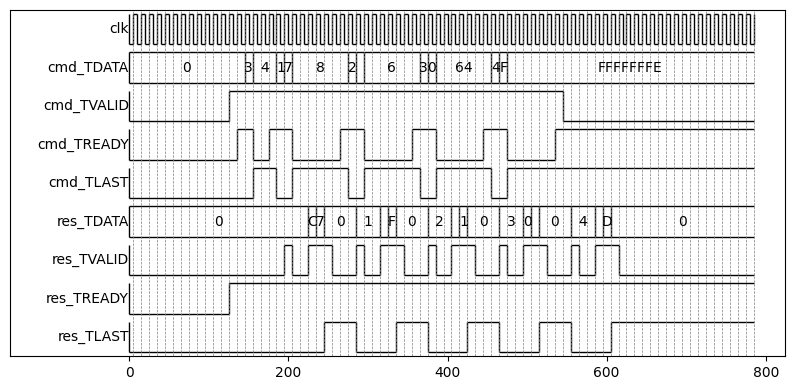

In [10]:

trange = None
vw.plot_signals(add_clk_grid=True, left_border=150, trange=trange, text_scale_factor=4000)

## Analyzing the AXI-Stream Bursts
It is useful to analyze the AXI-Stream bursts in more details.  For this purpose, we can use the `extract_axis_bursts` method in the `VCDViewer` class.  We see that we get a list, `bursts` with one item per burst.  

In [ ]:
bursts, clk_period= vw.extract_axis_bursts(clk_name, cmd_str_sigs)

for burst in bursts:
    for k, v in burst.items():
        print(f"{k}: \n")
    print()

{'data': [np.uint32(0), np.uint32(3), np.uint32(4)], 'start_idx': 13, 'beat_type': [0, 0, 2, 2, 0], 'tstart': np.float64(135.0)}
{'data': [np.uint32(1), np.uint32(7), np.uint32(8)], 'start_idx': 18, 'beat_type': [0, 0, 2, 2, 2, 2, 2, 2, 0], 'tstart': np.float64(185.0)}
{'data': [np.uint32(2), np.uint32(4294967291), np.uint32(6)], 'start_idx': 27, 'beat_type': [0, 0, 2, 2, 2, 2, 2, 2, 0], 'tstart': np.float64(275.0)}
{'data': [np.uint32(3), np.uint32(0), np.uint32(100)], 'start_idx': 36, 'beat_type': [0, 0, 2, 2, 2, 2, 2, 2, 0], 'tstart': np.float64(365.0)}
{'data': [np.uint32(4), np.uint32(15), np.uint32(4294967294)], 'start_idx': 45, 'beat_type': [0, 0, 2, 2, 2, 2, 2, 2, 0], 'tstart': np.float64(455.0)}


[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]
[6.32, 3.2800000000000002]


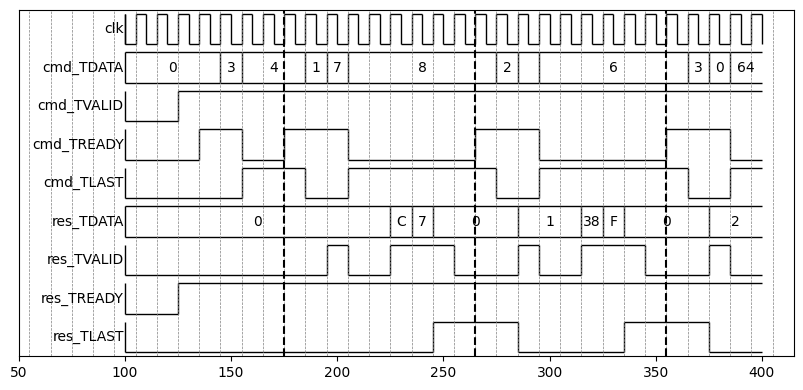

In [187]:
trange = [100,400]
ax = vw.plot_signals(add_clk_grid=True, left_border=50, trange=trange)

for burst in bursts:
    tstart = burst['tstart']
    nbeats = len(burst['beat_type'])

    # Check if burst is within trange
    if trange is not None:
        if (tstart < trange[0]) or (tstart + nbeats * clk_period) > trange[1]:
            continue

    for i in range(nbeats):
        beat_type = burst['beat_type'][i]
        if beat_type == 0:  # transfer. Color region in light green
            color = 'lightgreen'
        elif beat_type == 1:  # idle. Color region in light gray
            color = 'lightgray'
        elif beat_type == 2:  # stall. Color region in light coral
            color = 'lightcoral'
        t0 = tstart + (i-1) * clk_period
        t1 = tstart + i * clk_period

        ytop = vw.ytop['cmd_TDATA']
        ybot = vw.ybot['cmd_TLAST']
        print([ytop, ybot])

        # Draw a shaded region for the beat
        ax.axvspan(t0, t1, ymin=ybot, ymax=ybot, color=color, alpha=0.5)
        
    # Draw a vertical line at the end of the burst
    tend = tstart + (nbeats-1) * clk_period
    ax.axvline(tend, color='black', linestyle='--')
        

In [55]:
for kw in ['tdata', 'tready', 'tlast', 'tvalid']:
    print(vw.sig_info[cmd_str_sigs[kw]].times)
    print(vw.sig_info[cmd_str_sigs[kw]].disp_values)

[  0. 145. 155. 185. 195. 205. 275. 285. 295. 365. 375. 385. 455. 465.
 475.]
['0', '3', '4', '1', '7', '8', '2', 'FFFFFFFB', '6', '3', '0', '64', '4', 'F', 'FFFFFFFE']
[  0. 135. 155. 175. 205. 265. 295. 355. 385. 445. 475. 535.]
['0', '1', '0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
[  0. 155. 185. 205. 275. 295. 365. 385. 455. 475.]
['0', '1', '0', '1', '0', '1', '0', '1', '0', '1']
[  0.  125.1 145.  155.  185.  195.  205.  275.  285.  295.  365.  375.
 385.  455.  465.  475.  545. ]
['0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0']


The following code:
* Creates a viewing class
* Adds the **status signals** such as `start`, `idle` that tell when the IP should execute.
* Adds the **S-AXI-Lite signals** for the interface for the processor to read and write to the Vitis IP.
* Creates the timing diagram for the signals.


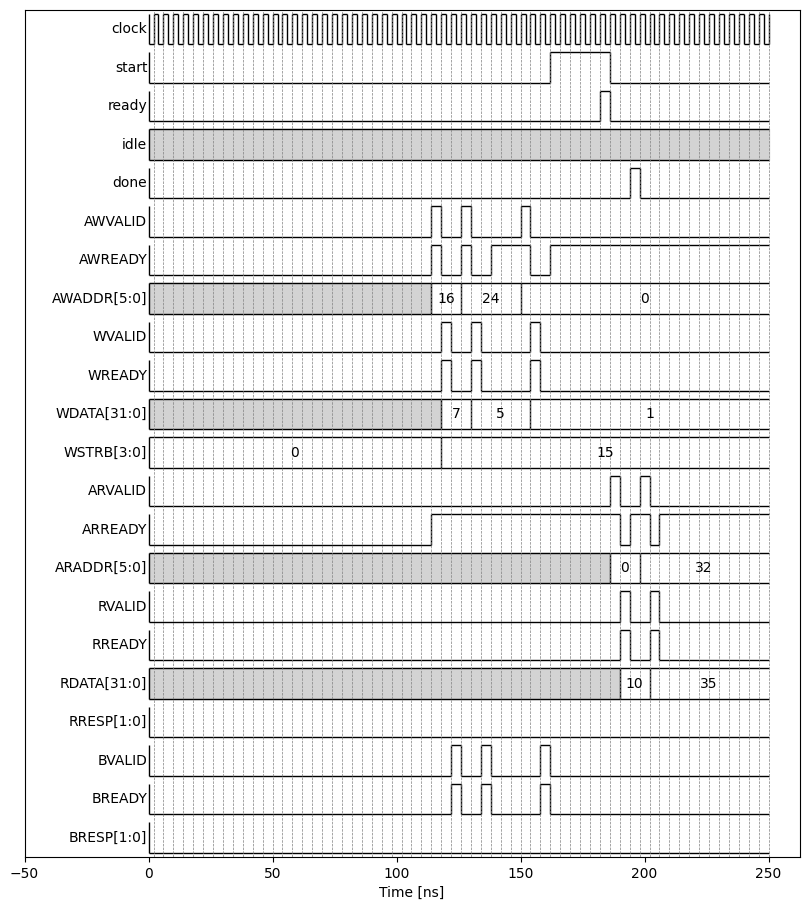

In [9]:
# Create a viewing class
vw = VcdViewer(vcd)

# Add status and S-AXI-Lite signals
vw.add_status_signals()
vw.add_saxi_signals()

# Plot the timing diagram
ax = vw.plot_signals(left_border=50)
ax.set_xlabel('Time [ns]')
plt.show()


We can see the various phases of the **execution model**:

* The testbench first writes the two inputs to the IP:
    * Write  `WDATA = 7` and `5` to addresses `AWADDR = 16` and `24`
* Starts execution with `start=1`
* IP completes execution with strobing `done=1`
* Testbench reads the result `RDATA=12` from read address `ARADDR = 32`.

False
